# Plot emulator calls for a given model

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
# our own modules
import simplest_emulator
import data_PD2013
import mean_flux_model
import thermal_model
import camb_cosmo
import fit_linP
import recons_cosmo
import compute_likelihood

### Specify suite of simulations to use, read P1D arxiv and setup simplest emulator

In [2]:
basedir='/Users/font/CosmoData/test_sim_emulator/test_medium/'
#basedir='../mini_sim_suite/'
skewers_label='Ns100_wM0.1'
emu=simplest_emulator.SimplestEmulator(basedir,skewers_label,verbose=True)

latin hyper-cube data {'param_space': {'Om_star': {'ip': 0, 'min_val': 0.955, 'max_val': 0.975, 'z_star': 3.0, 'latex': '$\\Omega_\\star$'}, 'Delta2_star': {'ip': 1, 'min_val': 0.25, 'max_val': 0.45, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\Delta^2_\\star$'}, 'mu_He': {'ip': 2, 'min_val': 0.5, 'max_val': 2.0, 'latex': '$\\mu_{\\rm He}$'}}, 'nsamples': 5, 'samples': {'0': [0.961, 0.39, 1.25], '1': [0.965, 0.31, 0.9500000000000001], '2': [0.969, 0.35, 1.55], '3': [0.973, 0.27, 0.65], '4': [0.957, 0.43000000000000005, 1.85]}}
simulation suite has 5 samples
0 sample has sim params = [0.961, 0.39, 1.25]
simulation has 7 redshifts
/Users/font/CosmoData/test_sim_emulator/test_medium//sim_pair_0 does not have this snapshot 0
1 sample has sim params = [0.965, 0.31, 0.9500000000000001]
simulation has 7 redshifts
/Users/font/CosmoData/test_sim_emulator/test_medium//sim_pair_1 does not have this snapshot 0
2 sample has sim params = [0.969, 0.35, 1.55]
simulation has 7 redshifts
/Users/font/Cosmo

### Read P1D data from Palanque-Delabrouille et al. (2013), to get redshift bins

In [3]:
basedir='../../p1d_data/data_files/PD2013/'
data=data_PD2013.P1D_PD2013(basedir=basedir)
zs=data.z
# while testing, use only a handful of bins
zs=data.z[::4]
Nz=len(zs)

### Setup nuisance models

In [4]:
mf_model=mean_flux_model.MeanFluxModel(z_tau=4.5)
#mf_model=mean_flux_model.MeanFluxModel()
T_model=thermal_model.ThermalModel()

In [5]:
z=3.4
print('<F>(z=%.2f) = %f'%(z,mf_model.get_mean_flux(z)))
print('T_0(z=%.2f) = %f'%(z,T_model.get_T0(z)))
print('gamma(z=%.2f) = %f'%(z,T_model.get_gamma(z)))

<F>(z=3.40) = 0.800759
T_0(z=3.40) = 10000.000000
gamma(z=3.40) = 1.456532


### Setup cosmological model

In [6]:
# specify cosmology
cosmo = camb_cosmo.get_cosmology(mnu=0.15, ns=0.965, omch2=0.12)
# print relevant information about the cosmology object
camb_cosmo.print_info(cosmo)

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 1.6128E-03, T_CMB = 2.7255E+00, A_s = 2.1000E-09, n_s = 9.6500E-01, alpha_s = 0.0000E+00


In [7]:
# compute linear power parameters, around z_star and kp_kms
z_star=3.0
kp_kms=0.009
linP_model=fit_linP.LinearPowerModel(cosmo,z_star=z_star,k_units='kms',kp=kp_kms)
linP_model.get_params()

{'Delta2_star': 0.34359089153174016,
 'alpha_star': -0.21586983258446132,
 'f_star': 0.97514327990258953,
 'g_star': 0.968209492732573,
 'n_star': -2.300572652881717}

### Use fiducial cosmology to reconstruct input cosmology

In [8]:
# setup fiducial cosmology
cosmo_fid = camb_cosmo.get_cosmology()
# reconstruct cosmology using linear parameter model (at z_star, kp_kms)
rec_cosmo=recons_cosmo.ReconstructedCosmology(linP_model,cosmo_fid)
# compute linear power parameters at each redshift (in Mpc)
linP_Mpc_params=rec_cosmo.get_linP_Mpc_params(zs)

Note: redshifts have been re-sorted (earliest first)


### For a given pair of parameters, plot arxiv and emulator calls

In [9]:
emu_calls=[]
for iz in range(Nz):
    # acess data for this redshift
    z=zs[iz]
    # get emulator parameters for linear power, at this redshift (in Mpc)
    call=linP_Mpc_params[iz]
    # get emulator parameters for nuisance models, at this redshift
    call['mF']=mf_model.get_mean_flux(z)
    call['gamma']=T_model.get_gamma(z)
    T0=T_model.get_T0(z)
    sigT_kms=thermal_model.thermal_broadening_kms(T0)
    dkms_dMpc=rec_cosmo.reconstruct_Hubble(z)/(1+z)
    call['sigT_Mpc']=sigT_kms/dkms_dMpc
    emu_calls.append(call)

In [10]:
def overplot_parameter_pair(emu,emu_calls,param_1,param_2,zs=None):
    # figure out values of param_1,param_2 called
    call_1=[emu_call[param_1] for emu_call in emu_calls]
    print(param_1,'was called at',call_1)
    call_2=[emu_call[param_2] for emu_call in emu_calls]
    print(param_2,'was called at',call_2)
    # figure out values of param_1,param_2 in arxiv
    emu_1=np.array([emu.arxiv.data[i][param_1] for i in range(len(emu.arxiv.data))])
    print(param_1,'first values in arxiv',emu_1[:5])
    emu_2=np.array([emu.arxiv.data[i][param_2] for i in range(len(emu.arxiv.data))])
    print(param_2,'first values in arxiv',emu_2[:5])
    # overplot
    if zs is not None:
        emu_z=np.array([emu.arxiv.data[i]['z'] for i in range(len(emu.arxiv.data))])
        zmin=min(emu_z)
        zmax=max(emu_z)
        plt.scatter(emu_1,emu_2,c=emu_z,s=1,vmin=zmin, vmax=zmax)
        plt.scatter(call_1,call_2,c=zs,s=50,vmin=zmin, vmax=zmax)
        cbar=plt.colorbar()
        cbar.set_label("Redshift", labelpad=+1)
    else:
        plt.scatter(emu_1,emu_2,s=5)
        plt.scatter(call_1,call_2,s=25)        
    plt.xlabel(param_1)
    plt.ylabel(param_2)

mF was called at [0.92246016594360691, 0.84865765105517121, 0.74600413851372327]
Delta2_p was called at [0.52940508668690001, 0.3963222761532938, 0.30758350505290799]
mF first values in arxiv [ 0.68991821  0.65999682  0.63335376  0.60933539  0.58747571]
Delta2_p first values in arxiv [ 0.17524516  0.17524516  0.17524516  0.17524516  0.17524516]


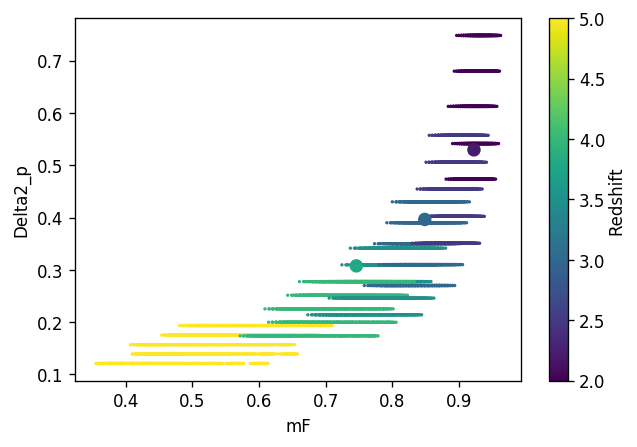

In [11]:
overplot_parameter_pair(emu,emu_calls,'mF','Delta2_p',zs)

In [12]:
emu.arxiv.cube_data

{'nsamples': 5,
 'param_space': {'Delta2_star': {'ip': 1,
   'kp_Mpc': 0.7,
   'latex': '$\\Delta^2_\\star$',
   'max_val': 0.45,
   'min_val': 0.25,
   'z_star': 3.0},
  'Om_star': {'ip': 0,
   'latex': '$\\Omega_\\star$',
   'max_val': 0.975,
   'min_val': 0.955,
   'z_star': 3.0},
  'mu_He': {'ip': 2,
   'latex': '$\\mu_{\\rm He}$',
   'max_val': 2.0,
   'min_val': 0.5}},
 'samples': {'0': [0.961, 0.39, 1.25],
  '1': [0.965, 0.31, 0.9500000000000001],
  '2': [0.969, 0.35, 1.55],
  '3': [0.973, 0.27, 0.65],
  '4': [0.957, 0.43000000000000005, 1.85]}}